In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from skopt import gp_minimize
from statistics import stdev, variance, mean
from fastai.tabular.all import *
from fastai.collab import CollabDataLoaders, collab_learner
from surprise import Reader, Dataset, accuracy, SVD
from surprise.model_selection import KFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## Exploratory Analysis

In [89]:
# Import of taining and test data
train = pd.read_csv("dados/train.csv")
test = pd. read_csv("dados/test.csv")
jokes = pd.read_csv("dados/jokes.csv")
print("Train " + str(train.shape))
print("Test " + str(test.shape))

Train (1092059, 4)
Test (537880, 3)


In [57]:
train.head(), print("Train " + str(train.shape))

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [54]:
test.head(), print("Test " + str(test.shape))

,id,user_id,joke_id
0,6194_11,6194,11
1,19356_3,19356,3
2,23426_79,23426,79
3,40030_3,40030,3
4,19806_115,19806,115


In [6]:
jokes.head()

,joke_id,joke_text
0,1,"Q. What's O. J. Simpson's web address? A. Slash, slash, backslash, slash, slash, escape."
1,2,How many feminists does it take to screw in a light bulb? That's not funny.
2,3,Q. Did you hear about the dyslexic devil worshiper? A. He sold his soul to Santa.
3,4,"They asked the Japanese visitor if they have elections in his country. ""Every morning,"" he answers."
4,5,Q: What did the blind person say when given some matzah? A: Who the hell wrote this?


In [6]:
train["joke_text"] = train.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])
test["joke_text"] = test.joke_id.apply(lambda x: jokes.loc[jokes.joke_id == x, "joke_text"][x-1])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092059 entries, 0 to 1092058
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id       1092059 non-null  object 
 1   user_id  1092059 non-null  int64  
 2   joke_id  1092059 non-null  int64  
 3   Rating   1092059 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.3+ MB


In [8]:
# Cheching uniqueness of data
train.select_dtypes(["int64", "float64", "object"]).nunique().sort_values().to_frame().T

,joke_id,Rating,user_id,id
0,139,641,40863,1092059


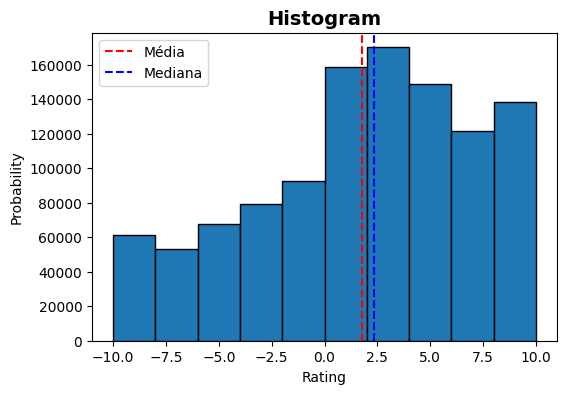

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(train.Rating, edgecolor="black")
plt.title("Histogram", fontweight="bold", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.axvline(train.Rating.mean(), color="red", linestyle="--")
plt.axvline(train.Rating.median(), color="blue", linestyle="--")
plt.legend(title="", labels=["Média","Mediana"], ncol=1, loc="best")
plt.show()

In [73]:
#
mean(train.Rating)

1.7583939732193956

In [10]:
#
stdev(train.Rating)

5.2308597557955006

In [11]:
#
variance(train.Rating)

27.361893784800966

## Models

### Fastai Model

In [37]:
dls = CollabDataLoaders.from_df(
    train, 
    user_name="user_id", 
    item_name="joke_id", 
    rating_name="Rating", 
    bs=2000,
    valid_pct=0.2, 
    shuffle_train=True,
    seed=2
)

dls.show_batch()

,user_id,joke_id,Rating
0,34442,115,-9.000
1,9170,25,5.594
2,15977,56,8.781
3,3819,79,5.969
4,25425,60,7.656
5,33836,80,8.125
6,1835,102,9.844
7,14403,2,1.250
8,34980,52,-4.625
9,28947,23,9.188


In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))
    
def RMSELossFlat(*args, axis=-1, floatify=True, **kwargs):
    return BaseLoss(RMSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

SuggestedLRs(valley=0.0003981071640737355)

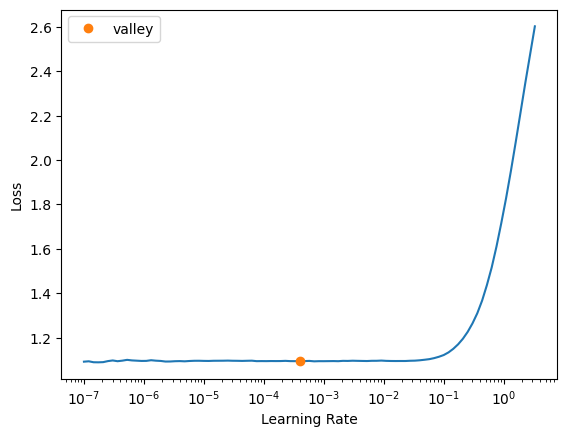

In [35]:
model = collab_learner(dls, use_nn=False, y_range=(-10. ,10.), n_factors=250, loss_func=RMSELossFlat())
model.lr_find()

In [53]:
model.fit_one_cycle(n_epoch=35, lr_max=10e-2, wd=0.3)

epoch,train_loss,valid_loss,time
0,1.375863,4.137762,00:46
1,3.422408,4.331400,00:48
2,4.336032,4.554557,00:48
3,4.740074,4.800587,00:59
4,5.127922,5.192208,01:15
5,5.490827,5.534153,01:04
6,5.790657,5.787431,00:49
7,5.957973,5.955312,00:46
8,6.027506,6.039778,00:47
9,6.021982,6.013632,00:49


In [54]:
model.show_results()

,user_id,joke_id,Rating,Rating_pred
0,20909.0,132.0,-8.281,1.407827
1,12543.0,103.0,2.656,1.131916
2,30495.0,84.0,7.094,1.621963
3,8821.0,15.0,2.094,2.736691
4,11616.0,79.0,-1.375,1.140109
5,33991.0,46.0,5.438,5.759834
6,25076.0,5.0,4.938,-1.727879
7,10868.0,25.0,7.219,3.873819
8,40328.0,53.0,4.031,2.554638


In [55]:
pp = model.dls.test_dl(test)
preds, _ = model.get_preds(dl=pp)

### Surprise Model

In [117]:
reader = Reader(rating_scale=(-10., 10.)) #-10.5,10.5
data = Dataset.load_from_df(train[["user_id", "joke_id", "Rating"]], reader)

In [121]:
kf = KFold(n_splits=25)
#model_svd = SVD(n_factors=500, n_epochs=100, lr_all=0.0055, random_state=2) n_splits=25 e 30
model_svd = SVD(n_factors=500, n_epochs=100, lr_all=0.00555, random_state=2)

In [123]:
mrmse = []
kfold = 0

for trainset, testset in kf.split(data):
    model_svd.fit(trainset)
    predic = model_svd.test(testset)
    result = accuracy.rmse(predic, verbose=False)
    print("Fold:", kfold + 1, "RMSE:", round(result, 10))
    mrmse.append(result)
    kfold += 1
    
print("Média RMSE CV", round(mean(mrmse), 10))

Fold:  1 RMSE:  4.022289370340527
Fold:  2 RMSE:  4.0030755881100175
Fold:  3 RMSE:  3.9840049604115317
Fold:  4 RMSE:  4.045928850445007
Fold:  5 RMSE:  4.0232118181527845
Fold:  6 RMSE:  3.9999168038161805
Fold:  7 RMSE:  4.0181869943287225
Fold:  8 RMSE:  4.018355984813058
Fold:  9 RMSE:  4.029950074720913
Fold:  10 RMSE:  4.0022735052625835
Fold:  11 RMSE:  4.006741803289909
Fold:  12 RMSE:  4.019602402057769
Fold:  13 RMSE:  4.001053862144809
Fold:  14 RMSE:  4.029977285808684
Fold:  15 RMSE:  4.025786711551644
Fold:  16 RMSE:  4.0517520050084
Fold:  17 RMSE:  4.0312090128704225
Fold:  18 RMSE:  4.000973896114834
Fold:  19 RMSE:  4.025907350188501
Fold:  20 RMSE:  3.9900847122979184
Fold:  21 RMSE:  4.021038763486209
Fold:  22 RMSE:  4.022063861844037
Fold:  23 RMSE:  4.00684332997686
Fold:  24 RMSE:  4.036499347905089
Fold:  25 RMSE:  4.02524695538104
Média RMSE CV 4.01767901


In [115]:
pred = []

for i in trange(test.shape[0]):
    pred.append((test.iloc[i, 0], model_svd.predict(test.iloc[i, 1], test.iloc[i, 2])[3]))

100%|██████████| 537880/537880 [01:24<00:00, 6347.77it/s]


In [69]:
min_svd = []

def svd_bayesian(params):
    model_svd = SVD(n_factors=params[0], n_epochs=params[1], lr_all=params[2], reg_all=params[3], verbose=False, random_state=2)
    for trainset, testset in kf.split(data):
        model_svd.fit(trainset)
        predic = model_svd.test(testset)
        min_svd.append(accuracy.rmse(predic, verbose=True))
    
    return min(min_svd)

print("Média RMSE CV", round(mean(min_svd), 10))

In [ ]:
pbounds = [
    (300, 500), #n_factors
    (20, 200), #n_epochs
    (0.0005, 0.5, "log-uniform"), #lr_all
    (0.005, 0.01, "log-uniform") #reg_all
]

res = gp_minimize(svd_bayesian, pbounds, verbose=1, n_calls=5, n_random_starts=2)

## Submission

In [116]:
# Submission surprise model
sub = pd.DataFrame(pred, columns = ["id", "Rating"])
sub.to_csv("submission.csv", index = False)

In [56]:
# Submission fastai model
test["Rating"] = preds
test.loc[:, ["id", "Rating"]].to_csv("submission.csv", index=False)
test.head()

,id,user_id,joke_id,Rating
0,6194_11,6194,11,1.157151
1,19356_3,19356,3,-0.514256
2,23426_79,23426,79,4.685508
3,40030_3,40030,3,-2.414566
4,19806_115,19806,115,6.191740
